## Introduction

The notebook demonstrates the use of <b> aireo_lib </b>, a python library created as a part of the [AIREO](https://aireo.net/) (Artificial Intelligence Ready Earth Observation training datasets) project. The project aims to make EO datasets easily accessible for the ML (Machine Learning) community. As such, AIREO specifications (shorthand specs) which define metadata elements to be included with the training dataset are proposed, supplemented by a best-practices document which suggests how to fill those metadata elements. Finally, the library takes all into account and implements specs, best-practices and offers an easy-to-use pythonic interface bridging the gap between EO and ML community.

Therefore, this notebook is divided into two sections, one for the training dataset creator (usually from the EO community) and the other for its user (usually from the ML community). The structure of the notebook is the following:


1) For Creator 

    - Create a [STAC](https://stacspec.org/) catalog object using the library
    
    - Populate metadata elements prescribed by the AIREO specs
    
    - Generate a STAC metadata directory using the library

    - Check AIREO compliance level and metadata completeness

   
2) For User 

    - Create a training dataset object as defined in the library using only the STAC metadata
    
    - Get example instances from the object and other dataset variables like the number of instances, etc.
    
    - Use library's functions to plot the data
    
    - Investigate statistics using the library

#### About the training dataset

The AI4Artic ASIP Sea Ice Dataset contains 461 files in network Common Data Form (netCDF), coming from Sentinel 1 SAR and AMSR2 microwave radiometer imagery with corresponding ice charts from Danish Meteorological Institute of the Arctic area.

Data is in netCDF format with over 300 GB of it accompanied by a well written manual. Sentinel 1 data is 90m resolution with 40 x 40m pixel spacing and AMSR2 data is resmpled to its pixels. Each satellite image comes with a timestamp and the data is acquired between 2018-2019. It also contains excel sheet where it can be found all images IDs along with the percentage of water and ice present per image. Finally it contains as well a shapefile with all S1 scenes bounding boxes.

## TDS Description

## AIREO STAC Catalog basics

The AIREO specs propose a hierarchical structure for STAC metadata. It is a two level structure where the dataset is represented by a collection of AOIs (Area Of Interests), hence, the dataset and AOI being the two levels.

1. At the dataset level we have a dataset catalog whose metadata elements are the core elements proposed in the AIREO spec. In addition to it, the common metadata elements across each AOI are also at the dataset level, which we shall call root level henceforth. Here, for each data variable there is a separate json which is a STAC Item by definition and is named using the field_schema metadata element. Additionally, there is also a datasheet file in markdown format at the root level which contains human readable information about the key elements of the dataset.

2. Each AOI has a separate folder within the root level. And in each AOI folder there is a STAC collection representing that AOI and additional json files for each data variable. The additional json files here too, are STAC Items and follow a similar naming convention to the ones at the root level. The assets for each AOI, i.e. the files containing actual data are also in the folder.

The diagram below summarises this hierarchical structure:


```
Root level (dataset)
│
│   DatasetCatalog.json
│   datasheet.md
│   references_output1.json
│   features_input1.json
│   ...
│
│
└───AOI 1
│      1.json (AOI Collection)
│      feature_input1.json
│      reference_output1.json
│      <reference_asset>
│      <feature_asseet>
│   
│   
└───AOI 2
│      ...
│   
│
└───AOI 3
│      ...
│   
...     
```

## Creating a STAC catalog with aireo_lib

The aireo_lib library makes it easier to generate the STAC metadata directory as defined above. Some of the useful functionalities in the library are:
-  Define python dictionaries for metadata at the root level and use a simple function to add it to the STAC catalog. The library validates the data automatically when it is added.

- Similarly, python dictionaries can be defined for each AOI and are also validated automatically.

- Links and assets for all the json files are automatically generated.

- Datasheet is also generated automatically.

- The directory structure is created by the library and assets copied to their respective locations in the hierarchy.

- Evaluating metadata completeness and compliance level.


Follow the code and comments below to understand the steps needed to generate STAC metadata with the library.

In [4]:
import aireo_lib.core
import os
import json
import numpy as np
from osgeo import gdal
from shapely import geometry
import rioxarray
import xarray as xr
from pathlib import Path
import pandas as pd
import geopandas as gp
import glob

from importlib import reload
reload(aireo_lib.core)


<module 'aireo_lib.core' from '/home/jovyan/s3/aireo_python_library/src/aireo_lib/core.py'>

In [2]:
# Path to write the STAC root metadata file too
catalog_fn_w_path = './sea-ice_stac_generated/EO_TDS.json'

# Creating an empty STAC Catalog object
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog()

In [3]:
#Gather some metadata files to be used to create the STAC catalog

url = "./dataset/S1_frames.shp"
fgdf = gp.read_file(url)

reference_path = './dataset/Data_ice_water.xlsx'
df = pd.read_excel(reference_path)

# Get AOI list for the TDS

aoi_ids = glob.glob(r'./dataset/sea-ice_nc/*')
aoi_ids = [x.split('/')[-1].split('.')[0] for x in aoi_ids]
aoi_ids

['20180404T205505_S1B_AMSR2_Icechart-Greenland-CentralWest']

In [26]:
# Creating root metadata dictionary

tds_root_core_metadata_d = {}
tds_root_core_metadata_d['aireo_version'] = "0.0.1-alpha.1"
tds_root_core_metadata_d['title'] = "AI4Artic ASIP Sea Ice Dataset"
tds_root_core_metadata_d['description'] = "AI4Artic ASIP Sea Ice Dataset contains 461 files in network Common Data Form (netCDF), coming from Sentinel 1 SAR and AMSR2 microwave radiometer imagery with corresponding ice charts from Danish Meteorological Institute of the Arctic area."
tds_root_core_metadata_d['created'] = "Null"
tds_root_core_metadata_d['license_url_list'] = 'https://creativecommons.org/licenses/by/4.0/deed.de' 
tds_root_core_metadata_d['license'] = "CC-BY-4.0"
tds_root_core_metadata_d["providers_name"]= "[Danish Meteorological Institute (DMI), the Technical University of Denmark (DTU) and Nansen Environmen-tal Remote Sensing Center (NERSC), AIREO]"
tds_root_core_metadata_d["providers_description"] = "Danish Meteorological Institute (DMI), the Technical University of Denmark (DTU) and Nansen Environmen-tal Remote Sensing Center (NERSC)"
tds_root_core_metadata_d["providers_roles"] = {'AIREO':["producer", "processor" , "host"],'DMI, DTU, NERSC':["producer", "processor" ]}
tds_root_core_metadata_d["providers_url"]= {'DMI':'https://www.dmi.dk/', 'DTU':'https://www.dtu.dk', 'NERSC':'https://www.nersc.no/', 'AIREO': 'https://aireo.net/'}                         
tds_root_core_metadata_d['id'] =  "270460aa-7835-11eb-9439-0242ac130002"
tds_root_core_metadata_d['type'] = "Collection"
tds_root_core_metadata_d['stac_version'] = '1.0.0-beta.2'
tds_root_core_metadata_d['provenance'] = 'The AI4Arctic sea ice dataset –version 2, ASID-v2, includes 461 files in netCDF format; two channel dual polarized(HH and HV) Sentinel-1 Extra WideSwath (EW) images, withboth ESA and NERSC noise correction;auxiliary Sentinel-1 image parameters,microwave radiometer measurements from the AMSR2 sensor on board the JAXA GCOM-W satellite, the corresponding DMI ice chart based on that Sentinel-1 image,'
tds_root_core_metadata_d['purpose'] = "Data is in netCDF format with over 300 GB of it accompanied by a well written manual. Sentinel 1 data is 90m resolution with 40 x 40m pixel spacing and AMSR2 data is resmpled to its pixels. Each satellite image comes with a timestamp and the data is acquired between 2018-2019. These can be used to perform semantic segmentation to infer sea ice level."
tds_root_core_metadata_d['tasks'] =  ['Semantic Segmentation']
tds_root_core_metadata_d['data_preprocessing'] = "Null"
tds_root_core_metadata_d['funding_info'] = "The AIREO project is funded by ESA, the AI4Arctiv sea ice dataset was funded by ESA Contract No. 4000129762/20/I-NB and Innovation Fund Denmark, Grant: 7049-00008B"
tds_root_core_metadata_d['field_schema'] = {'features': {'input1': ['georeferenced_eo_image']}, 'references': {'output1': ['reference_data']}}
tds_root_core_metadata_d['example_definition'] = "An example for ML training would be one satellite image with various bands as features and the mask as reference data. This can be used for predicting sea ice levels."
tds_root_core_metadata_d['example_window_size'] = 256
tds_root_core_metadata_d['example_stride'] = 26
                                                 
tds_root_core_metadata_d['data_completeness'] = "The dataset contains 461 netCDF files covering a large area with corresponding masks for sea-ice level for all areas."
tds_root_core_metadata_d['data_split'] = "The dataset can be split in a number of different ways but a standard way is to take 70% of the aoi's for training, 10% for validation and the remaining 20% as a test set."
tds_root_core_metadata_d['data_sharing'] = "The dataset will be shared on Euro Data Cube (EDC) and can be accessed through jupyter notebooks on EDC."
tds_root_core_metadata_d['compliance_level'] = 'level 1'
tds_root_core_metadata_d['links'] =  []


In [27]:
#Creating common predictive feature metadata dictionary

g_feature_metadata_d = {}
g_feature_metadata_d['type'] = "Feature"
g_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
g_feature_metadata_d['stac_extensions'] = ["georeferenced_eo_image"]
g_feature_metadata_d['id'] = f'common_predictive_feature_metadata'
g_feature_metadata_d['collection'] = "270460aa-7835-11eb-9439-0242ac130002"

geom = np.array(fgdf[fgdf['filename'] == '20180521T103156_S1B_AMSR2_Icechart-Greenland-NorthWest.nc']['geometry'][0].exterior.coords.xy)
xs = geom[0]
ys = geom[1]
xys = zip(xs,ys)
arr = []
for x, y in xys:
    arr.append([x,y])
g_feature_metadata_d['geometry'] = {'type': 'Polygon', 'coordinates': [arr]}
g_feature_metadata_d['bbox'] = [min(xs),min(ys), max(xs), max(ys)]
g_feature_metadata_d['properties'] = {}
g_feature_metadata_d["properties"]["status"]= "Null"
g_feature_metadata_d["properties"]['parent_identifier'] = "270460aa-7835-11eb-9439-0242ac130002"
g_feature_metadata_d["properties"]['acquisition_type'] = "Null"
g_feature_metadata_d["properties"]['product_type']  = "Null"
g_feature_metadata_d["properties"]['processing_level'] = 1.0
g_feature_metadata_d["properties"]['platform_short_name'] = "Sentinel 2"
g_feature_metadata_d["properties"]['sensor_type'] = "SAR"
g_feature_metadata_d["properties"]['sensor_resolution'] = "10m"
g_feature_metadata_d["properties"]['gsd'] = 10
g_feature_metadata_d['properties']['datetime'] = "2019"
g_feature_metadata_d["properties"]['identifier'] = "Null"
g_feature_metadata_d['links'] = []
g_feature_metadata_d["assets"] =  {}
feature_metadata_d = {}
feature_metadata_d['input1'] = g_feature_metadata_d

In [28]:
#Creating common reference metadata dictionary

g_ref_data_metadata_d = {}

g_ref_data_metadata_d['id'] = f'common_reference_metadata'
g_ref_data_metadata_d['type'] = "Feature"
g_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
g_ref_data_metadata_d['stac_extensions'] = ["reference_data"]
g_ref_data_metadata_d['collection'] = "270460aa-7835-11eb-9439-0242ac130002"

geom = np.array(fgdf[fgdf['filename'] == '20180521T103156_S1B_AMSR2_Icechart-Greenland-NorthWest.nc']['geometry'][0].exterior.coords.xy)
xs = geom[0]
ys = geom[1]
xys = zip(xs,ys)
arr = []
for x, y in xys:
    arr.append([x,y])
g_ref_data_metadata_d['geometry'] = {'type': 'Polygon', 'coordinates': [arr]}
g_ref_data_metadata_d['bbox'] = [min(xs),min(ys), max(xs), max(ys)]
g_ref_data_metadata_d['properties'] = {}
g_ref_data_metadata_d["properties"]['name'] = " Reference metadata"
g_ref_data_metadata_d['properties']['description'] = "The reference data consists of polygons with the percentage of sea ice for a given mask."
g_ref_data_metadata_d['properties']['type'] = "Raster"
g_ref_data_metadata_d['properties']['task'] = "Semantic Segmentation"
g_ref_data_metadata_d['properties']['classes'] = [[{'pct_ice': 416, 'pct_water': 416, 'pct_nodata': 416}]]
g_ref_data_metadata_d['properties']['overviews'] = []
g_ref_data_metadata_d['properties']['collection_method'] = "Sentinel-1 Synthetic Aperture Radar (SAR) scenes matched with sea ice charts produced by the Danish Meteorological Institute in 2018-2019."
g_ref_data_metadata_d['properties']['data_preprocessing'] = "Null"
g_ref_data_metadata_d['properties']['CRS'] = 'EPSG:32631'
g_ref_data_metadata_d['properties']['time_range'] = '2018-2019'

g_ref_data_metadata_d["properties"]['value'] = 0
g_ref_data_metadata_d['properties']["orientation"]= "Null"
g_ref_data_metadata_d["properties"]['datetime'] = "2019"
g_ref_data_metadata_d['links'] = []
g_ref_data_metadata_d["assets"] = {}

ref_metadata_d = {}
ref_metadata_d['output1'] = g_ref_data_metadata_d

In [29]:
# Add TDS global core elements metadata, and add global level profile metadata to the catalog object.

new_tds_ctl_o.add_tds_root_metadata(tds_root_core_metadata_d, feature_metadata_d, ref_metadata_d)


True

In [30]:
# Adding metadata for each AOI

for idx, aoi_id in enumerate(aoi_ids):
    # Dictionary for each AOI collection metadata
    aoi_metadata_d = {}
    aoi_metadata_d['type'] = "Collection"
    aoi_metadata_d["id"] = f"{aoi_id}"
    aoi_metadata_d['stac_version'] = '1.0.0-beta.2'
    aoi_metadata_d['title'] = f"{aoi_id} Collection"
    aoi_metadata_d['description'] = "Each AOI contains satellite images with crop masks."
    aoi_metadata_d["license"] = "CC-BY-4.0"
    mask = aoi_id + '.nc'
    #aoi_metadata_d['geometry'] = fgdf[fgdf['filename'] == '20180521T103156_S1B_AMSR2_Icechart-Greenland-NorthWest.nc']['geometry'][0]
    geom = np.array(fgdf[fgdf['filename'] == mask]['geometry'].values[0].exterior.coords.xy)
    xs = geom[0]
    ys = geom[1]
    minx = min(xs)
    miny = min(ys)
    maxx = max(xs)
    maxy = max(ys)
    aoi_metadata_d['bbox'] = [minx, miny, maxx, maxy]
    #aoi_metadata_d["bbox"]= [minx, miny, maxx, maxy]
    aoi_metadata_d['geometry'] = geometry.mapping(geometry.box(*aoi_metadata_d["bbox"]))
    aoi_metadata_d["extent"] = {"spatial" : {"bbox":[[minx, miny, maxx, maxy]]}, 
                      "temporal": {"interval":[[aoi_id[:4]]]}}
    aoi_metadata_d['time_range'] = '2019'
    aoi_metadata_d['links'] = []
    aoi_metadata_d["assets"] = {}
    
    
    # Dictionary for each AOI's predictive feature metadata
    aoi_feature_metadata_d = {}
    aoi_feature_metadata_d['id'] = f'reference_metadata_AOI_{aoi_id}'
    aoi_feature_metadata_d['type'] = "Feature"
    aoi_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_feature_metadata_d['stac_extensions'] = ["reference_data"]
    aoi_feature_metadata_d['collection'] = "270460aa-7835-11eb-9439-0242ac130002"
    aoi_feature_metadata_d['bbox'] = aoi_metadata_d["bbox"]
    aoi_feature_metadata_d['geometry'] = aoi_metadata_d["geometry"]
    aoi_feature_metadata_d['properties'] = {}
    aoi_feature_metadata_d["properties"]['name'] = str(aoi_id) + " Reference metadata"
    aoi_feature_metadata_d['properties']['description'] = "AI4Artic ASIP Sea Ice Dataset contains 461 files in network Common Data Form (netCDF), coming from Sentinel 1 SAR and AMSR2 microwave radiometer imagery with corresponding ice charts from Danish Meteorological Institute of the Arctic area."
    aoi_feature_metadata_d['properties']['type'] = "Raster"
    aoi_feature_metadata_d['properties']['task'] = "Semantic Segmentation"
    aoi_feature_metadata_d['properties']['classes'] = [[{'pct_ice': 416, 'pct_water': 416, 'pct_nodata': 416}]]
    aoi_feature_metadata_d['properties']['overviews'] = []
    aoi_feature_metadata_d['properties']['collection_method'] = "Sentinel-1 Synthetic Aperture Radar (SAR) scenes matched with sea ice charts produced by the Danish Meteorological Institute in 2018-2019."
    aoi_feature_metadata_d['properties']['data_preprocessing'] = "Null"
    aoi_feature_metadata_d['properties']['CRS'] = 'EPSG:32631'
    aoi_feature_metadata_d['properties']['time_range'] = aoi_id[:4]
    aoi_feature_metadata_d["properties"]['value'] = 0
    aoi_feature_metadata_d['properties']["orientation"]= "null"
    aoi_feature_metadata_d["properties"]['datetime'] = "2020-03-09T14:53:23.262208+00:00"

    aoi_feature_metadata_d['links'] = []  
    aoi_feature_metadata_d["assets"] = {}

    aoi_feature_d = {}
    aoi_feature_d['input1'] = aoi_feature_metadata_d
    
    # Dictionary for each AOI's reference metadata
    aoi_ref_data_metadata_d = {}
    aoi_ref_data_metadata_d['type'] = "Feature"
    aoi_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_ref_data_metadata_d['stac_extensions'] = ["georeferenced_eo_image"]
    aoi_ref_data_metadata_d['id'] = f'predictive_feature_metadata_AOI_{aoi_id}'
    aoi_ref_data_metadata_d['collection'] = "270460aa-7835-11eb-9439-0242ac130002"
    aoi_ref_data_metadata_d["bbox"]= aoi_metadata_d["bbox"]
    aoi_ref_data_metadata_d['geometry'] = aoi_metadata_d["geometry"]
    aoi_ref_data_metadata_d["properties"] = {}
    aoi_ref_data_metadata_d["properties"]["status"]= "Null"
    aoi_ref_data_metadata_d["properties"]['parent_identifier'] = "270460aa-7835-11eb-9439-0242ac130002"
    aoi_ref_data_metadata_d["properties"]['acquisition_type'] = "Null"
    aoi_ref_data_metadata_d["properties"]['product_type']  = "Null"
    aoi_ref_data_metadata_d["properties"]['processing_level'] = 1.0
    aoi_ref_data_metadata_d["properties"]['platform_short_name'] = "Sentinel 2"
    aoi_ref_data_metadata_d["properties"]['sensor_type'] = "SAR"
    aoi_ref_data_metadata_d["properties"]['sensor_resolution'] = "10m"
    aoi_ref_data_metadata_d["properties"]['gsd'] = 10
    aoi_ref_data_metadata_d["properties"]['identifier'] = str(aoi_id)
    aoi_ref_data_metadata_d["properties"]['acquisition_date'] = '2019'
    aoi_ref_data_metadata_d["properties"]['datetime'] = "2019"
    aoi_ref_data_metadata_d['links'] = []
    aoi_ref_data_metadata_d["assets"] = {}
    aoi_ref_d = {}
    aoi_ref_d['output1'] = aoi_ref_data_metadata_d
    
    aoi_ref_data_asset_path_d = {'output1':os.path.join(r'./dataset/sea-ice_mask', f'patch_mask_{aoi_id}.json')}
    aoi_feature_asset_path_d = {'input1':os.path.join(r'./dataset/sea-ice_tiff', f'patch_{aoi_id}.tif')}
                                            
    print(new_tds_ctl_o.add_aoi_metadata(aoi_metadata_d=aoi_metadata_d,
                                   aoi_feature_metadata_d=aoi_feature_d,
                                   aoi_ref_data_metadata_d=aoi_ref_d,
                                   aoi_feature_asset_path_d=aoi_feature_asset_path_d,
                                   aoi_ref_data_asset_path_d=aoi_ref_data_asset_path_d))


True
True
True
True


In [1]:
# If a STAC catalog has already been generated remove it before re generating the catalog below
import shutil
shutil.rmtree('../cap_stac_generated')

In [32]:
# Writing the STAC metadata. The directory along with its structure is generated, with correct links and assets defined. 
#A datasheet is also generated
catalog_fn_w_path = r'./sea-ice_stac_generated/TDS.json'
new_tds_ctl_o.write_TDS_STAC_Catalog(catalog_fn_w_path)

##### Checking AIREO compiance level

In [33]:
catalog_fn_w_path = r'./sea-ice_stac_generated/TDS.json'
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog.from_TDSCatalog(catalog_fn_w_path)
new_tds_ctl_o.compute_compliance_level()

1

##### Checking metadata completeness

In [34]:
new_tds_ctl_o.report_metadata_completeness()

{'tds_core_metadata': {'required_metadata': 1.0,
  'recommended_metadata': 0.3333333333333333,
  'optional_metadata': 0.23529411764705882}}

#### Defining AOI class

In [97]:
file = '/Users/adam/sea_ice/sea-ice_stac_generated/20180327T104059_S1B_AMSR2_Icechart-Greenland-CentralWest/patch_mask_20180327T104059_S1B_AMSR2_Icechart-Greenland-CentralWest.json'
with open(file, 'r') as f:
        #print(f.read())
        data = json.load(f)
        print(data)
print(data['pct_ice'])
#xr.Dataset.to_dict(dictio)
t = [data['pct_ice']]
x = [1,2]
y = [1,2]
d = {
    "pct_ice": {"dims": ("t"), "data": t},
}

xr.Dataset.from_dict(d)

{'pct_ice': 12, 'pct_water': 0, 'pct_nodata': 88}
12


<xarray.Dataset>
Dimensions:  (t: 1)
Dimensions without coordinates: t
Data variables:
    pct_ice  (t) int64 12

In [133]:
#should inherit AOIDataset

from aireo_lib.core import AOIDataset

class AOIDatasetSeaIce(AOIDataset):

    def __init__(self, AOI_STAC_collection, TDS_STAC_catalog):

        self.AOI_STAC_collection = AOI_STAC_collection
        self.TDS_STAC_catalog = TDS_STAC_catalog
        self.stride = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_stride']
        self.window_size = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_window_size']
        
        _first = True
        
        for eo_feature in self.AOI_STAC_collection.aoi_all_field_metadata.features:
            aoi_feature_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.features[eo_feature].data_asset_w_path
            self.feature_var_name = 'features_' + eo_feature
            if _first:
                self.data = rioxarray.open_rasterio(aoi_feature_asset_path_d).to_dataset(name = self.feature_var_name)
                _first = False
            else:
                self.data[self.feature_var_name] = rioxarray.open_rasterio(aoi_feature_asset_path_d)
        
        for reference_data in self.AOI_STAC_collection.aoi_all_field_metadata.references:
            aoi_ref_data_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.references[reference_data].data_asset_w_path
            self.ref_var_name = 'references_'+ reference_data
            if _first:
                with open(aoi_ref_data_asset_path_d, 'r') as f:
                    data = json.load(f)
                t = [data['pct_ice']]
                x = [data['pct_water']]
                y = [data['pct_nodata']]
                d = {
                    "pct_ice": {"dims": ("t"), "data": t},
                    "pct_ice": {"dims": ("t"), "data": x},
                    "pct_ice": {"dims": ("t"), "data": y},
                }
                self.data = xr.Dataset.from_dict(d).to_dataset(name = self.ref_var_name).to_array()
                print(self.data)
                _first = False
            else:
                with open(aoi_ref_data_asset_path_d, 'r') as f:
                    data = json.load(f)
                t = [data['pct_ice']]
                x = [data['pct_water']]
                y = [data['pct_nodata']]
                d = {
                    "pct_ice": {"dims": ("t"), "data": t},
                    "pct_ice": {"dims": ("t"), "data": x},
                    "pct_ice": {"dims": ("t"), "data": y},
                }
                self.data[self.ref_var_name] = xr.Dataset.from_dict(d).to_array().rename({'t':'mask'})
        


    def __getitem__(self, index):
        
        along_x = int((self.data[self.feature_var_name].shape[1] - self.window_size)/self.stride)
        along_y = int((self.data[self.feature_var_name].shape[-1] - self.window_size)/self.stride)
        x1 = self.stride * int(index % along_x)
        y1 = self.stride * int(index / along_y)
        x2 = x1 + self.window_size
        y2 = y1 + self.window_size
        
        #store feature and reference data in same xarray, name the axes
        ds = self.data.isel(band=[0], mask=[0], x=slice(x1,x2), y=slice(y1, y2))        
        return ds
    

    def __len__(self):
        
        along_x = int((self.data[self.feature_var_name].shape[1] - self.window_size)/self.stride) + 1
        along_y = int((self.data[self.feature_var_name].shape[-1] - self.window_size)/self.stride) + 1
        return along_x * along_y
    
    def get_length(self):
        return self.__len__()

## TDS user

The user of the dataset can access most of what is offered by the dataset using just its STAC catalog. All he/she needs to do is create a dataset object by passing to it the path to the STAC catalog at the root level. The library automatically reads in all the metadata and loads the assets into the dataset object. Some of the functionalities that a dataset object offers through aireo_lib are:

- Can access an example instance from the dataset which serves as an input-output pair for a Machine Learning algorithm.

- Xarrays are used to store data and give examples.

- Dataset can also return each AOI independently

- Offer basic plotting functions for each variable in the dataset and AOI.

- Some statistics can also be calculated at both the AOI level and whole dataset level.

### Parsing TDS

In [134]:
from aireo_lib.core import EOTrainingDataset

cap_tds_ctl_fn = Path(r'./sea-ice_stac_generated/TDS.json')

eo_tds_obj = EOTrainingDataset(cap_tds_ctl_fn, AOIDatasetSeaIce)

In [135]:
len(eo_tds_obj)

492376

In [128]:
eo_tds_obj[0]

<xarray.Dataset>
Dimensions:             (band: 1, mask: 1, variable: 1, x: 256, y: 256)
Coordinates:
  * band                (band) int64 1
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 252.5 253.5 254.5 255.5
  * y                   (y) float64 0.5 1.5 2.5 3.5 ... 252.5 253.5 254.5 255.5
    spatial_ref         int64 0
  * variable            (variable) <U7 'pct_ice'
Dimensions without coordinates: mask
Data variables:
    features_input1     (band, y, x) float32 ...
    references_output1  (variable, mask) int64 29

In [136]:
eo_tds_obj.get_subset([19,1121], data_type='numpy')

[<xarray.Dataset>
 Dimensions:             (band: 1, mask: 1, variable: 1, x: 256, y: 256)
 Coordinates:
   * band                (band) int64 1
   * x                   (x) float64 494.5 495.5 496.5 ... 747.5 748.5 749.5
   * y                   (y) float64 0.5 1.5 2.5 3.5 ... 252.5 253.5 254.5 255.5
     spatial_ref         int64 0
   * variable            (variable) <U7 'pct_ice'
 Dimensions without coordinates: mask
 Data variables:
     features_input1     (band, y, x) float32 ...
     references_output1  (variable, mask) int64 71,
 <xarray.Dataset>
 Dimensions:             (band: 1, mask: 1, variable: 1, x: 256, y: 256)
 Coordinates:
   * band                (band) int64 1
   * x                   (x) float64 9.698e+03 9.7e+03 ... 9.952e+03 9.954e+03
   * y                   (y) float64 52.5 53.5 54.5 55.5 ... 305.5 306.5 307.5
     spatial_ref         int64 0
   * variable            (variable) <U7 'pct_ice'
 Dimensions without coordinates: mask
 Data variables:
     features_in

In [137]:
aoi_objs = eo_tds_obj.get_aoi_datasets()
len(aoi_objs[1])

160394

### Plotting

In [138]:
import aireo_lib.plotting 
#import matplotlib.pyplot as plt
from importlib import reload
reload(aireo_lib.plotting)


<module 'aireo_lib.plotting' from '/Users/adam/aireo_python_library/src/aireo_lib/plotting.py'>

{'features_input1': <Figure size 432x288 with 2 Axes>,
 'references_output1': <Figure size 432x288 with 1 Axes>}

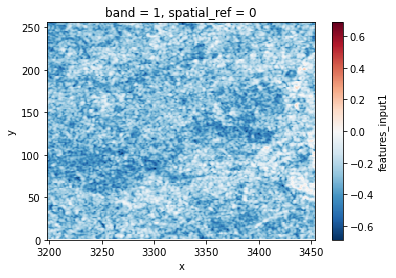

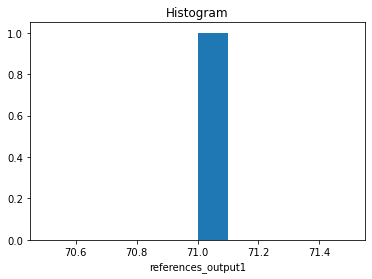

In [139]:
plot_d = aireo_lib.plotting.EOTDSPlot.plot_example(EOTDS=eo_tds_obj, 
                       ex_index=123, 
                       field_names=['features_input1', 'references_output1'])
plot_d

In [140]:
aoi_obj = eo_tds_obj.get_aoi_dataset(2)

{'features_input1': <Figure size 432x288 with 2 Axes>,
 'references_output1': <Figure size 432x288 with 1 Axes>}

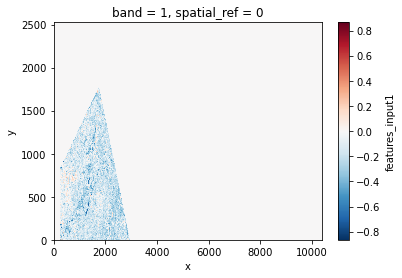

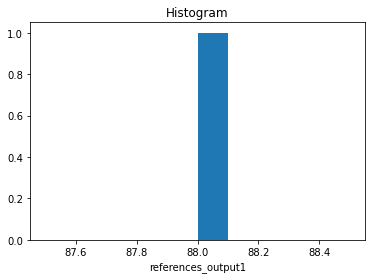

In [141]:
aoi_plots_d = aireo_lib.plotting.EOTDSPlot.plot_aoi_dataset(aoi_obj)
aoi_plots_d

### Statistics


In [142]:
import aireo_lib.statistics
from importlib import reload
reload(aireo_lib.statistics)

<module 'aireo_lib.statistics' from '/Users/adam/aireo_python_library/src/aireo_lib/statistics.py'>

In [143]:
aireo_lib.statistics.EOTDSStatistics.feature_data_statistics(eo_tds_obj)

{'aoi_0_channel_0': {'mean': -0.09384584426879883,
  'std': 0.16580742597579956,
  'max': 1.1482321,
  'min': -0.91193885},
 'aoi_1_channel_0': {'mean': -0.07520604133605957,
  'std': 0.1833912432193756,
  'max': 0.6308558,
  'min': -0.79776365},
 'aoi_2_channel_0': {'mean': -0.019468802958726883,
  'std': 0.06705166399478912,
  'max': 0.6557258,
  'min': -0.8648287},
 'aoi_3_channel_0': {'mean': -0.022560523822903633,
  'std': 0.08617173135280609,
  'max': 1.2389616,
  'min': -0.871593}}

In [144]:
aireo_lib.statistics.EOTDSStatistics.reference_data_statistics(eo_tds_obj)

{'references_output1_aoi0': Counter({71: 1}),
 'references_output1_aoi1': Counter({49: 1}),
 'references_output1_aoi2': Counter({88: 1}),
 'references_output1_aoi3': Counter({89: 1}),
 'whole_TDS_stats': {71: 1, 49: 1, 88: 1, 89: 1}}